In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
# read the shape file for elementary school districts in Durham
elem_durham =  gpd.read_file(r'./../data/elem_durham/elem_durham.shp')
elem_durham['coords'] = elem_durham['geometry'].apply(lambda x: x.representative_point().coords[:])
elem_durham['coords'] = [coords[0] for coords in elem_durham['coords']]

In [5]:
# read the shape file for the census blocks in Durham
block_durham = gpd.read_file(r'./../data/blk_shapefiles/tl_2018_37063_faces.shp')

In [6]:
df_elem_students = block_durham.loc[:,['STATEFP10','COUNTYFP10','TRACTCE10','BLOCKCE10']]

df_elem_students['GEOID10'] = df_elem_students['STATEFP10'] + df_elem_students['COUNTYFP10'] + df_elem_students['TRACTCE10'] + df_elem_students['BLOCKCE10']

df_elem_students  = df_elem_students.loc[:,['GEOID10']]

In [7]:
all_races = ['W','A','M','H','B']


for race in all_races:
    df_race = pd.read_csv(r'./../data/sex_age_race/sex_by_age_{}.csv'.format(race))
    df_race = convertHeader(df_race)
    df_race_elem = countElemStudents(df_race,race)
    df_elem_students = pd.merge(df_race_elem,df_elem_students, how = 'outer')



In [8]:
df_elem_students.sum(axis = 0)

GEOID10        inf
Total_B    22318.0
Total_H    11140.6
Total_M     3082.0
Total_A     2071.2
Total_W    24604.2
dtype: float64

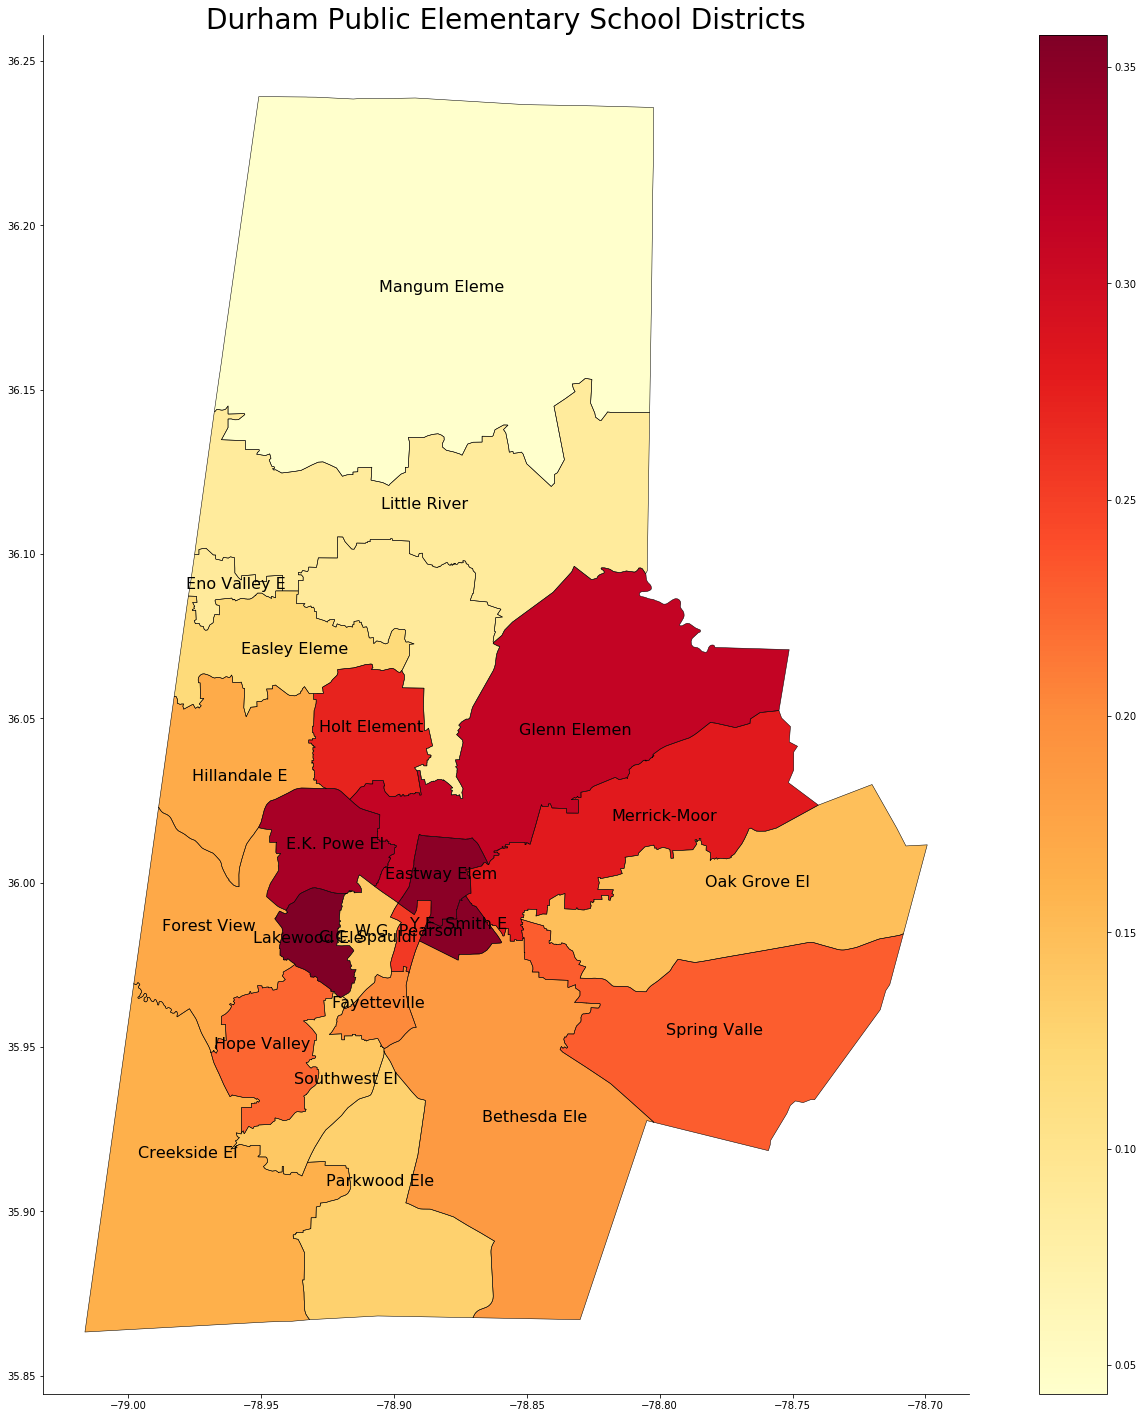

In [10]:
ig, ax = plt.subplots(1, 1,figsize=(25, 25))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Durham Public Elementary School Districts",fontsize = 28)
elem_durham.plot(ax = ax, legend = True, column = 'Pct_H',cmap = 'YlOrRd')
elem_durham.geometry.boundary.plot(color = None, edgecolor = 'k',linewidth = 0.5, ax = ax, vmin = 0, vmax = 1)
for idx, row in elem_durham.iterrows():
    plt.annotate(s=row['name'][0:12], xy=row['coords'],
                 horizontalalignment='center', fontsize = 16)

In [2]:
# convert the second row as the header, getting rid of !!
def convertHeader(df):
    df['GEO_ID'] = df['GEO_ID'].str[9:]
    df= df.rename(columns={'GEO_ID':'GEOID10'})
    df.columns = df.iloc[0]
    df = df.drop(index= 0).rename(columns = {"":'GEOID10'})

    cols = df.columns.tolist()
    for i in range(len(cols)):
        col = cols[i].replace( '!!',' ')
        cols[i] = col
    df.columns = cols
    return df

# find num of students of age 5-10 of each race in each block
def countElemStudents(df,race):
    elem_members = ['GEOID10','Total Male 5 to 9 years','Total Female 5 to 9 years','Total Male 10 to 14 years','Total Female 10 to 14 years']
    df_elem = df.loc[:,elem_members]
    for col in elem_members:#convert all columns to number format
        if col != 'GEOID10':
            df_elem[col] = pd.to_numeric(df_elem[col],errors = 'coerce')
    #assume kids are evenly distributed over different ages, so divide the column value by 5
    df_elem['Total Male 10 to 14 years'] = df_elem['Total Male 10 to 14 years']/5
    df_elem['Total Female 10 to 14 years'] = df_elem['Total Female 10 to 14 years']/5
    #sum over kids of all ages and genders
    df_elem['Total_{}'.format(race)] = df_elem.sum(axis = 1)
    return df_elem.loc[:,['GEOID10','Total_{}'.format(race)]]

def assignStuToSchools(block_durham, elem_durham,
                           race_column,
                           eps = 0.001):
    spatialIndex = elem_durham.sindex
    elem_durham[race_column] = 0
    for ii in block_durham.index:
        bgeom = block_durham.loc[ii,'geometry']
        possibleIndMatches = list(spatialIndex.intersection(bgeom.bounds))
        possibleMatches = elem_durham.iloc[possibleIndMatches]
        #if we only have 1 school that the kids in the block should go
        if len(possibleMatches) == 1:
            elem_durham.at[possibleIndMatches[0], race_column] += block_durham.loc[ii,race_column]
        else:
            #if we have multiple schools that the kids in the block can go
            intersectingAreas = possibleMatches.intersection(bgeom).area
            preciseMatches = possibleMatches[intersectingAreas/bgeom.area > eps]

            if len(preciseMatches) == 1:
                #if after narrowing down we have exactly one school to go
                ind = list(preciseMatches.index)[0]

                elem_durham.at[ind,race_column] += block_durham.loc[ii,race_column]

            #if we have multiple precise matches
            elif len(preciseMatches) > 1:
                totalOverlap = preciseMatches.intersection(bgeom).area.sum()
                #loop over the possible schools we can go in terms of 
                #their indices

                preciseIndMatches = preciseMatches.index
                preciseMatchAreas = preciseMatches.intersection(bgeom).area


                for idx in preciseIndMatches:
                    overlapRatio = preciseMatchAreas.loc[idx]/totalOverlap
                    stu = overlapRatio*block_durham.loc[ii,race_column]
                    elem_durham.at[idx,race_column] += int(round(stu))

            else: #in the case there is no intersection
                print('block {} students have no school to go'.format(ii))

        
            
            
    return elem_durham